In [1]:
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm
from rdkit import Chem
from scipy.stats import norm
from genbench3d.geometry import AnglePattern, TorsionPattern, BondPattern
from ccdc import io
from genbench3d.params import CSD_DRUG_SUBSET_PATH
from genbench3d.utils import ccdc_mol_to_rdkit_mol
from genbench3d.geometry import CSDDrugGeometry
from tqdm import tqdm
from ccdc.io import Molecule
from rdkit.Chem import Mol

/home/bb596/ssd/miniforge3/envs/csd/lib/python3.9/site-packages/sklearn/utils/multiclass.py:14: DeprecationWarning: Please use `spmatrix` from the `scipy.sparse` namespace, the `scipy.sparse.base` namespace is deprecated.
  from scipy.sparse.base import spmatrix
/home/bb596/ssd/miniforge3/envs/csd/lib/python3.9/site-packages/sklearn/utils/optimize.py:18: DeprecationWarning: Please use `line_search_wolfe2` from the `scipy.optimize` namespace, the `scipy.optimize.linesearch` namespace is deprecated.
  from scipy.optimize.linesearch import line_search_wolfe2, line_search_wolfe1
/home/bb596/ssd/miniforge3/envs/csd/lib/python3.9/site-packages/sklearn/utils/optimize.py:18: DeprecationWarning: Please use `line_search_wolfe1` from the `scipy.optimize` namespace, the `scipy.optimize.linesearch` namespace is deprecated.
  from scipy.optimize.linesearch import line_search_wolfe2, line_search_wolfe1


In [2]:
def plot_mixture(mixture):
    n_samples_total = 100000
    all_samples = []

    means = mixture.means_.reshape(-1)
    pis = mixture.weights_.reshape(-1)
    stds = mixture.covariances_.reshape(-1)
    for pi, mean, std in zip(pis, means, stds):
        n_samples = int(pi * n_samples_total)
        # print(n_samples, np.around(mean, 2), np.around(std, 2))
        samples = norm(loc=mean, scale=np.sqrt(std)).rvs(n_samples)
        all_samples.extend(samples)
        
    sns.histplot(all_samples)
    plt.show()
    
    return all_samples

In [3]:
rg = CSDDrugGeometry()

In [4]:
len(rg.mixtures['torsion'])

4552

In [4]:
with open('../hdd/ThreeDGenMolBenchmark/data/CSDDrug_geometry_values.p', 'rb') as f:
    values = pickle.load(f)

In [78]:
pattern_str = 'N{6,6,5,5,5}(~C,-H)~C{6,6,5,5,5}(~C)~C{6,6,5,5,5}(~N,~C)'
pattern = AnglePattern.from_string(pattern_str)

In [79]:
try:
    geometry_mixture = rg.mixtures['angle'][pattern]
except:
    geometry_mixture = rg.mixtures['angle'][pattern.generalize()]
geometry_values = values['angle'][pattern]

/home/bb596/ssd/miniforge3/envs/csd/lib/python3.9/site-packages/pandas/core/algorithms.py:485: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps.dtype], [])


<Axes: ylabel='Count'>

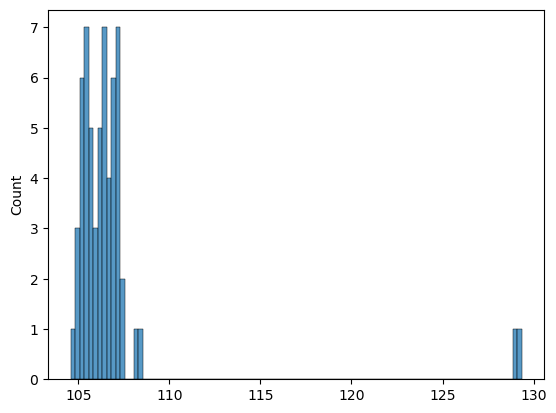

In [80]:
sns.histplot(geometry_values, bins=100)

/home/bb596/ssd/miniforge3/envs/csd/lib/python3.9/site-packages/pandas/core/algorithms.py:485: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps.dtype], [])


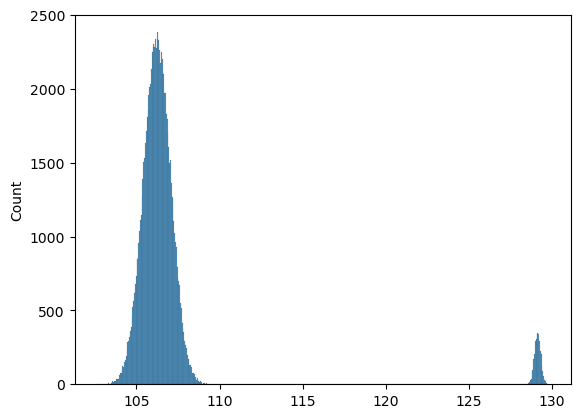

In [81]:
mixture = geometry_mixture.mixture
samples = plot_mixture(mixture)

In [69]:
mixture.means_

array([[121.01411786]])

/home/bb596/ssd/miniforge3/envs/csd/lib/python3.9/site-packages/pandas/core/algorithms.py:485: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps.dtype], [])


<Axes: >

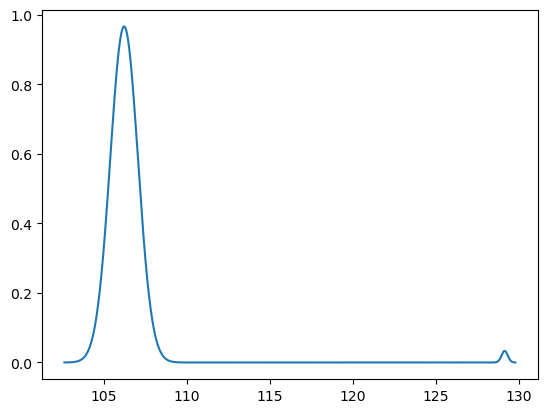

In [82]:
likelihoods = rg.get_likelihoods(mixture, samples)
sns.lineplot(x=samples, y=likelihoods)

In [41]:
mol_iterator = io.MoleculeReader('CSD')
subset_path = CSD_DRUG_SUBSET_PATH
subset_csd_ids = []
with open(subset_path, 'r') as f:
    for line in f.readlines():
        subset_csd_ids.append(line.strip())

In [46]:
writer = Chem.SDWriter('pattern_mols2.sdf')

for csd_id in tqdm(subset_csd_ids):
    try:
        include = False
        original_mol = mol_iterator.molecule(csd_id)
        if isinstance(original_mol, Molecule):
            try:
                mol = ccdc_mol_to_rdkit_mol(original_mol)
            except Exception as e:
                logging.warning('CCDC mol could not be converted to RDKit :' + str(e))
                mol = None
        else:
            mol = original_mol
        
        if mol is not None:
            assert isinstance(mol, Mol)
            Chem.SanitizeMol(mol)
            
            mol_angle_values = rg.get_mol_angle_values(mol)
            for angle_pattern, angle_values in mol_angle_values.items():
                if angle_pattern == pattern:
                    # print(f'pattern found: {angle_values}')
                    if any([value < 110 for value in angle_values]):
                        include = True
                        print(mol.GetProp('_Name'))

        if include:
            writer.write(mol)

    except Exception as e:
        print(e)

writer.close()

  1%|█▌                                                                                                           | 126/8632 [00:03<03:24, 41.51it/s]

DatabasePool::entry( DatabaseEntryIdentifier )(): AKATAJ is not in the database


  2%|██▎                                                                                                          | 185/8632 [00:05<04:03, 34.71it/s]

DatabasePool::entry( DatabaseEntryIdentifier )(): FAJMIP is not in the database


  3%|██▊                                                                                                          | 220/8632 [00:06<03:54, 35.85it/s]

DatabasePool::entry( DatabaseEntryIdentifier )(): KONZEU is not in the database


  3%|███                                                                                                          | 240/8632 [00:07<03:23, 41.20it/s]

DatabasePool::entry( DatabaseEntryIdentifier )(): QIJZOY01 is not in the database


  5%|█████▎                                                                                                       | 417/8632 [00:12<04:28, 30.60it/s]

DatabasePool::entry( DatabaseEntryIdentifier )(): EDAXIQ01 is not in the database


 10%|██████████▊                                                                                                  | 853/8632 [00:26<04:32, 28.51it/s]

DatabasePool::entry( DatabaseEntryIdentifier )(): NICOAC04 is not in the database


 19%|████████████████████▊                                                                                       | 1667/8632 [00:53<03:15, 35.55it/s]

DatabasePool::entry( DatabaseEntryIdentifier )(): CBMZPN26 is not in the database


 21%|██████████████████████▌                                                                                     | 1807/8632 [00:57<03:02, 37.49it/s]

DatabasePool::entry( DatabaseEntryIdentifier )(): OMAKOE is not in the database


 22%|███████████████████████▎                                                                                    | 1868/8632 [00:59<02:42, 41.54it/s]

DatabasePool::entry( DatabaseEntryIdentifier )(): WOBHUR01 is not in the database


 26%|████████████████████████████▎                                                                               | 2267/8632 [01:11<03:21, 31.62it/s]


KeyboardInterrupt: 

In [109]:
five_ring_smiles = 'C1=C([H])C([H])=C([H])N1'
five_ring_mol = Chem.MolFromSmiles(five_ring_smiles, sanitize=False)

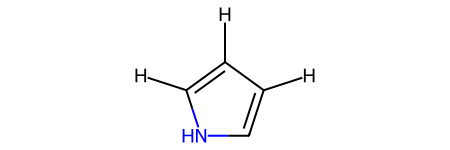

In [45]:
display(five_ring_mol)

In [51]:
for csd_id in tqdm(subset_csd_ids):
    try:
        original_mol = mol_iterator.molecule(csd_id)
        if isinstance(original_mol, Molecule):
            try:
                mol = ccdc_mol_to_rdkit_mol(original_mol)
            except Exception as e:
                logging.warning('CCDC mol could not be converted to RDKit :' + str(e))
                mol = None
        else:
            mol = original_mol

        Chem.Kekulize(mol)
        matches = mol.GetSubstructMatch(five_ring_mol, useChirality=True)
        if matches:
            import pdb;pdb.set_trace()
    
    except Exception as e:
        print(e)

  1%|▊                                                                                                            | 67/8632 [00:00<00:26, 327.41it/s]

Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)


  2%|█▋                                                                                                          | 135/8632 [00:00<00:27, 314.20it/s]

Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)
DatabasePool::entry( DatabaseEntryIdentifier )(): AKATAJ is not in the database


  3%|███                                                                                                         | 244/8632 [00:00<00:26, 312.10it/s]

Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)
Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)
DatabasePool::entry( DatabaseEntryIdentifier )(): FAJMIP is not in the database
DatabasePool::entry( DatabaseEntryIdentifier )(): KONZEU is not in the database
DatabasePool::entry( DatabaseEntryIdentifier )(): QIJZOY01 is not in the database


  4%|████▌                                                                                                       | 369/8632 [00:01<00:28, 286.13it/s]

Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)


  5%|█████▉                                                                                                      | 470/8632 [00:01<00:26, 308.45it/s]

DatabasePool::entry( DatabaseEntryIdentifier )(): EDAXIQ01 is not in the database


  6%|██████▋                                                                                                     | 532/8632 [00:01<00:27, 290.06it/s]

Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)


  8%|████████▌                                                                                                   | 686/8632 [00:02<00:30, 258.31it/s]

Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)


  9%|█████████▋                                                                                                  | 779/8632 [00:02<00:27, 286.27it/s]

Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)


 10%|██████████▌                                                                                                 | 842/8632 [00:02<00:29, 266.20it/s]

Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)
DatabasePool::entry( DatabaseEntryIdentifier )(): NICOAC04 is not in the database


 13%|█████████████▌                                                                                             | 1090/8632 [00:03<00:27, 278.68it/s]

Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)
Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)


 14%|██████████████▉                                                                                            | 1209/8632 [00:04<00:25, 287.46it/s]

Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)
Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)


 15%|████████████████▎                                                                                          | 1316/8632 [00:04<00:22, 330.81it/s]

Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)
Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)
Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)


 16%|█████████████████▌                                                                                         | 1420/8632 [00:04<00:22, 320.53it/s]

Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)
Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)


 17%|██████████████████▍                                                                                        | 1484/8632 [00:05<00:28, 249.10it/s]

Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)


 19%|███████████████████▊                                                                                       | 1597/8632 [00:05<00:29, 241.57it/s]

Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)


 20%|█████████████████████▎                                                                                     | 1717/8632 [00:06<00:24, 286.35it/s]

DatabasePool::entry( DatabaseEntryIdentifier )(): CBMZPN26 is not in the database
Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)
Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)


 21%|██████████████████████▍                                                                                    | 1814/8632 [00:06<00:28, 236.79it/s]

DatabasePool::entry( DatabaseEntryIdentifier )(): OMAKOE is not in the database


 22%|███████████████████████▋                                                                                   | 1909/8632 [00:06<00:24, 277.44it/s]

Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)
Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)
DatabasePool::entry( DatabaseEntryIdentifier )(): WOBHUR01 is not in the database
Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)


 23%|████████████████████████▍                                                                                  | 1975/8632 [00:07<00:22, 298.10it/s]

Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)
Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)
Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)
Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)


 24%|█████████████████████████▋                                                                                 | 2071/8632 [00:07<00:24, 271.95it/s]

Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)
Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)


 25%|██████████████████████████▍                                                                                | 2134/8632 [00:07<00:23, 273.34it/s]

Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)
Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)


 26%|████████████████████████████                                                                               | 2262/8632 [00:08<00:23, 266.18it/s]

Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)


 28%|█████████████████████████████▊                                                                             | 2408/8632 [00:08<00:23, 269.10it/s]

DatabasePool::entry( DatabaseEntryIdentifier )(): CBMZPN24 is not in the database


 29%|██████████████████████████████▌                                                                            | 2470/8632 [00:09<00:22, 279.93it/s]

Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)


 30%|███████████████████████████████▊                                                                           | 2571/8632 [00:09<00:20, 301.90it/s]

Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)
Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)


 31%|████████████████████████████████▉                                                                          | 2660/8632 [00:09<00:23, 256.20it/s]

Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)


 32%|██████████████████████████████████                                                                         | 2744/8632 [00:10<00:23, 254.65it/s]

Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)
DatabasePool::entry( DatabaseEntryIdentifier )(): NICOAC03 is not in the database


 33%|███████████████████████████████████▎                                                                       | 2849/8632 [00:10<00:18, 311.18it/s]

Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)
Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)


 37%|███████████████████████████████████████▎                                                                   | 3175/8632 [00:11<00:19, 283.29it/s]

Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)
Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)


 38%|████████████████████████████████████████▉                                                                  | 3303/8632 [00:12<00:19, 277.39it/s]

Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)


 39%|██████████████████████████████████████████▏                                                                | 3405/8632 [00:12<00:18, 281.55it/s]

Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)


 40%|██████████████████████████████████████████▉                                                                | 3465/8632 [00:12<00:21, 236.14it/s]

Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)
DatabasePool::entry( DatabaseEntryIdentifier )(): COTZAN06 is not in the database
Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)


 41%|████████████████████████████████████████████                                                               | 3559/8632 [00:12<00:17, 282.95it/s]

Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)
Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)


 43%|██████████████████████████████████████████████▎                                                            | 3735/8632 [00:13<00:17, 282.49it/s]

Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)
Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)
Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)
Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)


 45%|████████████████████████████████████████████████                                                           | 3877/8632 [00:14<00:15, 312.14it/s]

Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)


 46%|████████████████████████████████████████████████▉                                                          | 3943/8632 [00:14<00:15, 300.14it/s]

Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)
Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)


 46%|█████████████████████████████████████████████████▋                                                         | 4007/8632 [00:14<00:20, 226.24it/s]

Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)
Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)


 47%|██████████████████████████████████████████████████▍                                                        | 4065/8632 [00:14<00:19, 235.64it/s]

Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)


 49%|████████████████████████████████████████████████████▎                                                      | 4217/8632 [00:15<00:17, 250.49it/s]

Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)


 50%|█████████████████████████████████████████████████████▌                                                     | 4317/8632 [00:15<00:14, 300.34it/s]

Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)


 52%|███████████████████████████████████████████████████████▏                                                   | 4450/8632 [00:16<00:14, 288.20it/s]

Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)
Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)
DatabasePool::entry( DatabaseEntryIdentifier )(): JOHJIB02 is not in the database


 53%|████████████████████████████████████████████████████████▍                                                  | 4555/8632 [00:16<00:12, 325.50it/s]

Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)
DatabasePool::entry( DatabaseEntryIdentifier )(): JOHJIB03 is not in the database


 54%|█████████████████████████████████████████████████████████▎                                                 | 4624/8632 [00:16<00:12, 312.76it/s]

Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)


 56%|███████████████████████████████████████████████████████████▊                                               | 4821/8632 [00:17<00:14, 262.15it/s]

DatabasePool::entry( DatabaseEntryIdentifier )(): DUWXEA is not in the database
Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)


 57%|████████████████████████████████████████████████████████████▌                                              | 4889/8632 [00:17<00:12, 289.10it/s]

Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)


 57%|█████████████████████████████████████████████████████████████▎                                             | 4951/8632 [00:18<00:14, 257.21it/s]

Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)


 60%|████████████████████████████████████████████████████████████████▏                                          | 5180/8632 [00:19<00:11, 304.20it/s]

Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)


 61%|█████████████████████████████████████████████████████████████████▍                                         | 5279/8632 [00:19<00:13, 257.41it/s]

Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)
Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)
DatabasePool::entry( DatabaseEntryIdentifier )(): CBMZPN25 is not in the database
Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)


 63%|███████████████████████████████████████████████████████████████████▋                                       | 5465/8632 [00:20<00:11, 264.50it/s]

Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)
Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)


 64%|████████████████████████████████████████████████████████████████████▊                                      | 5550/8632 [00:20<00:11, 261.13it/s]

Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)
Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)
Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)


 65%|█████████████████████████████████████████████████████████████████████▍                                     | 5602/8632 [00:20<00:12, 241.83it/s]

DatabasePool::entry( DatabaseEntryIdentifier )(): FUFXOV is not in the database


 67%|███████████████████████████████████████████████████████████████████████▎                                   | 5755/8632 [00:21<00:10, 268.80it/s]

Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)
Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)
Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)
Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)


 67%|████████████████████████████████████████████████████████████████████████                                   | 5812/8632 [00:21<00:10, 273.56it/s]

Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)


 70%|██████████████████████████████████████████████████████████████████████████▌                                | 6014/8632 [00:22<00:08, 299.00it/s]

Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)
Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)


 72%|█████████████████████████████████████████████████████████████████████████████▍                             | 6249/8632 [00:22<00:07, 330.26it/s]

DatabasePool::entry( DatabaseEntryIdentifier )(): UNEYIV03 is not in the database
Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)


 75%|████████████████████████████████████████████████████████████████████████████████                           | 6459/8632 [00:23<00:06, 316.53it/s]

Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)
Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)


 76%|█████████████████████████████████████████████████████████████████████████████████▋                         | 6585/8632 [00:24<00:07, 278.47it/s]

Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)


 77%|██████████████████████████████████████████████████████████████████████████████████▊                        | 6678/8632 [00:24<00:06, 296.64it/s]

Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)
DatabasePool::entry( DatabaseEntryIdentifier )(): CASWOK is not in the database


 80%|█████████████████████████████████████████████████████████████████████████████████████▏                     | 6874/8632 [00:25<00:05, 305.36it/s]

Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)


 81%|██████████████████████████████████████████████████████████████████████████████████████▊                    | 6999/8632 [00:25<00:05, 278.87it/s]

Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)


 82%|███████████████████████████████████████████████████████████████████████████████████████▌                   | 7067/8632 [00:25<00:05, 305.81it/s]

Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)
Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)
Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)


 83%|█████████████████████████████████████████████████████████████████████████████████████████▎                 | 7203/8632 [00:26<00:04, 299.59it/s]

Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)
Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)
DatabasePool::entry( DatabaseEntryIdentifier )(): QQQAUG18 is not in the database


 84%|█████████████████████████████████████████████████████████████████████████████████████████▋                 | 7234/8632 [00:26<00:05, 270.30it/s]

Python argument types in
    rdkit.Chem.rdmolops.Kekulize(NoneType)
did not match C++ signature:
    Kekulize(RDKit::ROMol {lvalue} mol, bool clearAromaticFlags=False)
> /tmp/ipykernel_3118633/2606875397.py(1)<module>()
----> 1 for csd_id in tqdm(subset_csd_ids):
      2     try:
      3         original_mol = mol_iterator.molecule(csd_id)
      4         if isinstance(original_mol, Molecule):
      5             try:



ipdb>  Chem.MolToMolFile(mol, 'match.mol')


 84%|█████████████████████████████████████████████████████████████████████████████████████████▋                 | 7234/8632 [00:40<00:05, 270.30it/s]

ipdb>  mol.GetProp('_Name')


'UVITEZ'


ipdb>  exit


 84%|██████████████████████████████████████████████████████████████████████████████████████████▊                 | 7259/8632 [01:42<00:19, 71.02it/s]


In [24]:
name = 'UVITEZ'

In [25]:
original_mol = mol_iterator.molecule(name)
if isinstance(original_mol, Molecule):
    try:
        mol = ccdc_mol_to_rdkit_mol(original_mol)
    except Exception as e:
        logging.warning('CCDC mol could not be converted to RDKit :' + str(e))
        mol = None
else:
    mol = original_mol

In [26]:
mol_angle_values = rg.get_mol_angle_values(mol)

In [27]:
pattern_str

'C(~N,-N)~N()~C(-N,~C)'

In [28]:
for pattern, values in mol_angle_values.items():
    print(pattern.to_string())

F()-B[-1](-O,-O)-F()
F()-B[-1](-F,-O)-O(-C)
C(-N,-C)=C(-C)-O(-B)
O(-B)-C(=C)-C(=C,-H)
O(-C)-B[-1](-F,-F)-O(-C)
O(-B)-C(=C)-C(~N,~C)
C(-C,-H)=C(-C)-O(-B)
C(-C,-H)=C(-O)-C(~N,~C)
C(~C,-C)~N(-H)~C(~C,-H)
C(~C,-C)~N(~C)-H()
C(~N,-C)~C(-H)~C(~C,-H)
C(~N,-C)~C(~C)-H()
C(=C,-C)-O()-B[-1](-F,-F,-O)
C(-O,-C)=C(-C)-N[+1](=C,-H)
C(-O,-C)=C(-N)-C(=C,-H)
C(-O,-C)=C(-H)-C(-O,=C)
C(-O,=C)-C(=C)-H()
N(~C,-H)~C(~C)-C(-O,=C)
C(~C,-H)~C(~N)-C(-O,=C)
C(-O,-C)=C(-C)-H()
C(-N,-C)=C(-O)-C(=C,-H)
C(-C,-H)=N[+1](-H)-C(=C,-C)
C(=C,-C)-N[+1](=C)-H()
C(-C,-H)=C(-H)-C(-N,=C)
C(-N,=C)-C(=C)-H()
C(=N,-H)-C(=C)-H()
C(-C,-H)=C(-H)-C(=N,-H)
C(-C,-H)=N[+1](-C)-H()
C(=C,-H)-C(=N)-H()
N[+1](-C,-H)=C(-C)-H()
N[+1](-C,-H)=C(-H)-C(=C,-H)
C(-C,-H)=C(-C)-H()
C(~N,-H)~C(~C)-H()
C(~N,-H)~C(-H)~C(~C,-H)
C(~C,-H)~N(~C)-H()
C(~C,-H)~C(~N)-H()
N(~C,-H)~C(~C)-H()
N(~C,-H)~C(-H)~C(~C,-H)
C(~C,-H)~C(~C)-H()
N[+1](=C,-H)-C(=C)-C(=C,-H)
N(~C,-H)~C(-C)~C(~C,-H)
O()=C(-C)-O[-1]()
O[-1]()-C(=O)-C(~C,~C)
O()=C(-O)-C(~C,~C)
C(~C,-C)~C(~C)-H()

In [50]:
Chem.Kekulize(mol)

In [61]:
pattern_str = 'C(-N,-H)-C(-H,-H)-C(-H,-H)-C(-N,-H)'

In [54]:
pattern = TorsionPattern.from_string(pattern_str)

In [49]:
patterns = list(rg.mixtures['torsion'].keys())

In [55]:
geometry_mixture = rg.mixtures['torsion'][pattern]
geometry_values = values['torsion'][pattern]

/home/bb596/ssd/miniforge3/envs/csd/lib/python3.9/site-packages/pandas/core/algorithms.py:485: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps.dtype], [])


<Axes: ylabel='Count'>

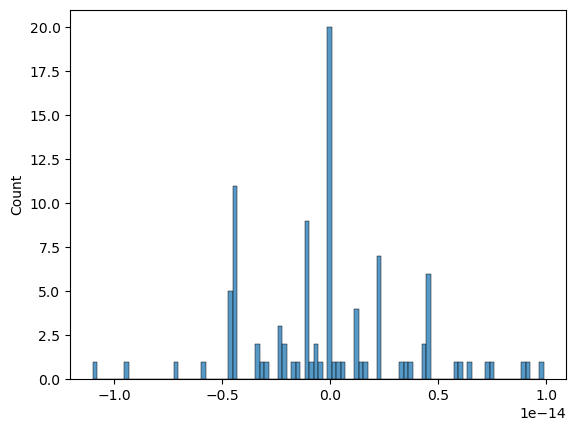

In [56]:
sns.histplot(geometry_values, bins=100)

/home/bb596/ssd/miniforge3/envs/csd/lib/python3.9/site-packages/pandas/core/algorithms.py:485: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps.dtype], [])


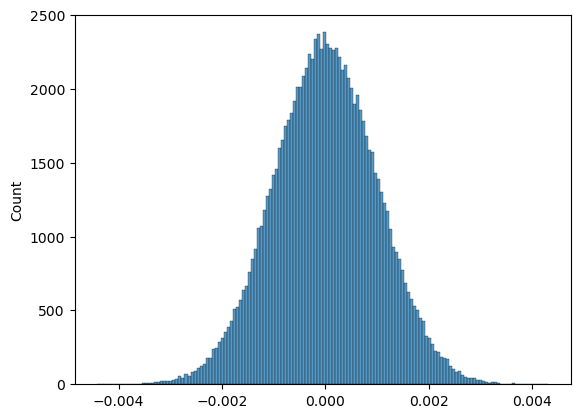

In [57]:
mixture = geometry_mixture.mixture
samples = plot_mixture(mixture)

In [60]:
mixture.covariances_

array([[[1.e-06]]])

/home/bb596/ssd/miniforge3/envs/csd/lib/python3.9/site-packages/pandas/core/algorithms.py:485: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps.dtype], [])


<Axes: >

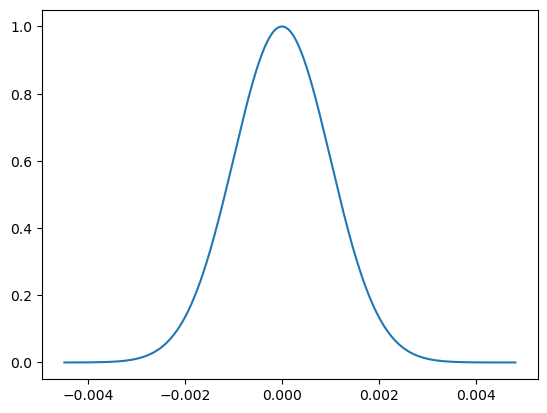

In [33]:
likelihoods = rg.get_likelihoods(mixture, samples)
sns.lineplot(x=samples, y=likelihoods)

/home/bb596/ssd/miniforge3/envs/csd/lib/python3.9/site-packages/pandas/core/algorithms.py:485: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps.dtype], [])


<Axes: >

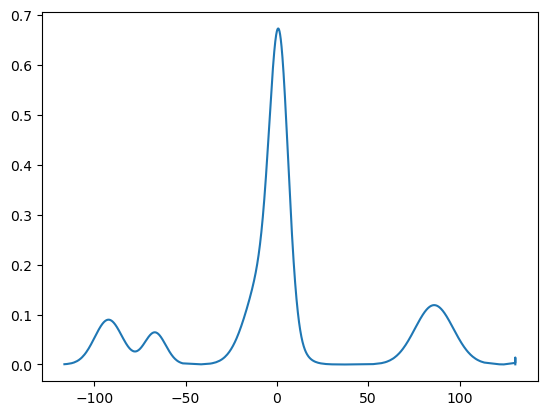

In [22]:
for pattern in rg.mixtures['bond'].keys():
    if pattern.to_string().startswith('C{6}(~C,~C)'):
        print(pattern.to_string())
        print()

C{6}(~C,~C)-C(-N,-H,-H)

C{6}(~C,~C)-H()

C{6}(~C,~C)-Cl()

C{6}(~C,~C)-C(-C,-H,-H)

C{6}(~C,~C)-O(-C)

C{6}(~C,~C)-N(-H,-H)

C{6}(~C,~C)-O(-H)

C{6}(~C,~C)-N(-C,-H)

C{6}(~C,~C)-C(-O,-C,-H)

C{6}(~C,~C)-C(=O,-O)

C{6}(~C,~C)-C(=C,-H)

C{6}(~C,~C)-C(=O,-N)

C{6}(~C,~C)-F()

C{6}(~C,~C)-C{6}(~C,~C)

C{6}(~C,~C)-C()

C{6}(~C,~C)=O()

C{6}(~C,~C)-C(-C,-C,-H)

C{6}(~C,~C)-S(=O,=O,-N)

C{6}(~C,~C)-C(=O,-C)

C{6}(~C,~C)-C(-N,-C,-H)

C{6}(~C,~C)-S(=O,=O,-O)

C{6}(~C,~C)-C(-O,-C,-C)

C{6}(~C,~C)-Br()

C{6}(~C,~C)-C(-H,-H,-H)

C{6}(~C,~C)-C(-C,-C,-C)

C{6}(~C,~C)-C(#N)

C{6}(~C,~C)-C(-F,-F,-F)

C{6}(~C,~C)-I()

C{6}(~C,~C)-N(-C,-C)



In [17]:
pattern.to_string()

'C{8,5,5}()-H()'

In [73]:
pattern_str = 'C{6}(~C,~C)-C(#N)'

In [74]:
pattern = BondPattern.from_string(pattern_str)

In [28]:
rg.mixtures['bond'][pattern.generalize()]

GeometryMixture(mixture=GaussianMixture(n_components=3), max_likelihood=0.6595577411582113, shift=0)

In [75]:
geometry_mixture = rg.mixtures['bond'][pattern]
geometry_values = values['bond'][pattern]

/home/bb596/ssd/miniforge3/envs/csd/lib/python3.9/site-packages/pandas/core/algorithms.py:485: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps.dtype], [])


<Axes: ylabel='Count'>

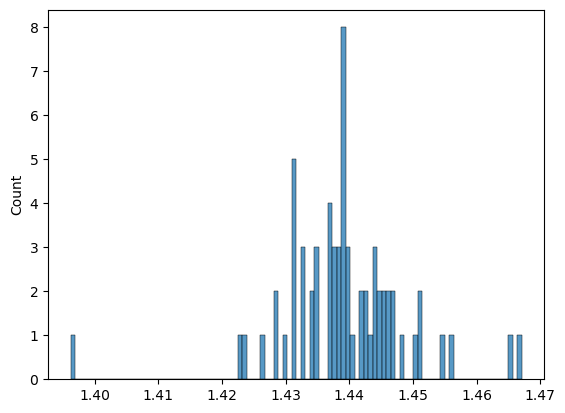

In [76]:
sns.histplot(geometry_values, bins=100)

/home/bb596/ssd/miniforge3/envs/csd/lib/python3.9/site-packages/pandas/core/algorithms.py:485: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps.dtype], [])


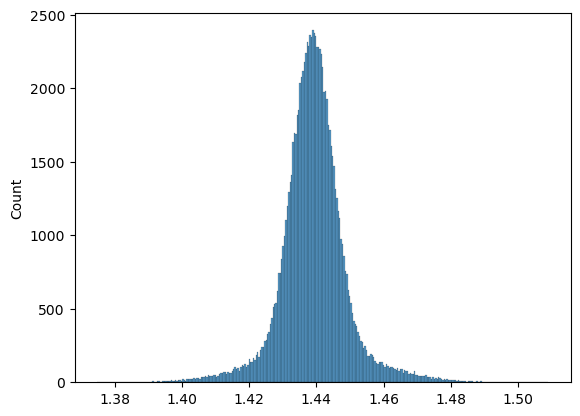

In [77]:
mixture = geometry_mixture.mixture
samples = plot_mixture(mixture)

In [110]:
smiles = 'OCC1=CC=CC1=O'
mol = Chem.MolFromSmiles(smiles)

In [113]:
ri = mol.GetRingInfo()

In [115]:
ri.BondRings()

((2, 3, 4, 5, 7),)

In [116]:
ri.AtomRings()

((2, 3, 4, 5, 6),)

In [119]:
ring_sizes = (6, 5)
'{' + ','.join([str(rs) for rs in ring_sizes]) + '}'

'{6,5}'

In [123]:
tuple([])

()

In [90]:
smiles = 'OCC1=CC=Cc1=o'
mol = Chem.MolFromSmiles(smiles)

In [91]:
mol

In [84]:
mol.Debug()

Atoms:
	0 8 O chg: 0  deg: 1 exp: 1 imp: 1 hyb: 4 arom?: 0 chi: 0
	1 6 C chg: 0  deg: 2 exp: 2 imp: 2 hyb: 4 arom?: 0 chi: 0
	2 6 C chg: 0  deg: 3 exp: 4 imp: 0 hyb: 3 arom?: 0 chi: 0
	3 6 C chg: 0  deg: 2 exp: 3 imp: 1 hyb: 3 arom?: 0 chi: 0
	4 6 C chg: 0  deg: 2 exp: 3 imp: 1 hyb: 3 arom?: 0 chi: 0
	5 6 C chg: 0  deg: 2 exp: 3 imp: 1 hyb: 3 arom?: 0 chi: 0
	6 6 C chg: 0  deg: 3 exp: 4 imp: 0 hyb: 3 arom?: 0 chi: 0
	7 8 O chg: 0  deg: 1 exp: 2 imp: 0 hyb: 3 arom?: 0 chi: 0
Bonds:
	0 0->1 order: 1 conj?: 0 aromatic?: 0
	1 1->2 order: 1 conj?: 0 aromatic?: 0
	2 2->3 order: 2 conj?: 1 aromatic?: 0
	3 3->4 order: 1 conj?: 1 aromatic?: 0
	4 4->5 order: 2 conj?: 1 aromatic?: 0
	5 5->6 order: 1 conj?: 1 aromatic?: 0
	6 6->7 order: 2 conj?: 1 aromatic?: 0
	7 6->2 order: 1 conj?: 1 aromatic?: 0


In [47]:
from genbench3d.geometry import ReferenceGeometry

In [49]:
likelihoods = rg.get_likelihoods(mixture, samples)

/home/bb596/ssd/miniforge3/envs/csd/lib/python3.9/site-packages/pandas/core/algorithms.py:485: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps.dtype], [])


<Axes: >

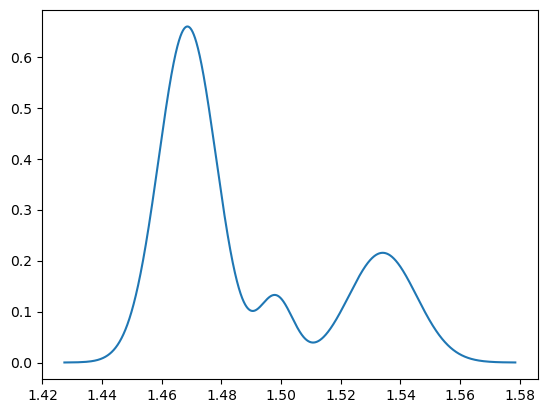

In [50]:
sns.lineplot(x=samples, y=likelihoods)

In [47]:
writer = Chem.SDWriter('pattern_mols.sdf')

for csd_id in tqdm(subset_csd_ids):
    try:
        original_mol = mol_iterator.molecule(csd_id)
        if isinstance(original_mol, Molecule):
            try:
                mol = ccdc_mol_to_rdkit_mol(original_mol)
            except Exception as e:
                logging.warning('CCDC mol could not be converted to RDKit :' + str(e))
                mol = None
        else:
            mol = original_mol
        
        if mol is not None:
            assert isinstance(mol, Mol)
            
            mol_bond_values = rg.get_mol_bond_lengths(mol)
            for bond_pattern, bond_values in mol_bond_values.items():
                if bond_pattern == pattern:
                    # print(f'pattern found: {bond_values}')
                    writer.write(mol)
                    if any([value > 1.53 for value in bond_values]):
                        print(mol.GetProp('_Name'))

    except Exception as e:
        print(e)

writer.close()

  2%|█▋                                                                                                           | 136/8632 [00:01<01:37, 87.51it/s]

DatabasePool::entry( DatabaseEntryIdentifier )(): AKATAJ is not in the database


  2%|██▌                                                                                                          | 198/8632 [00:02<01:33, 90.48it/s]

DatabasePool::entry( DatabaseEntryIdentifier )(): FAJMIP is not in the database


  3%|██▉                                                                                                          | 233/8632 [00:02<01:25, 98.45it/s]

DatabasePool::entry( DatabaseEntryIdentifier )(): KONZEU is not in the database
DatabasePool::entry( DatabaseEntryIdentifier )(): QIJZOY01 is not in the database


  5%|█████▎                                                                                                       | 423/8632 [00:04<01:30, 90.59it/s]

DatabasePool::entry( DatabaseEntryIdentifier )(): EDAXIQ01 is not in the database


 10%|██████████▊                                                                                                  | 858/8632 [00:10<01:48, 71.83it/s]

DatabasePool::entry( DatabaseEntryIdentifier )(): NICOAC04 is not in the database


 19%|█████████████████████                                                                                       | 1679/8632 [00:20<01:18, 88.99it/s]

DatabasePool::entry( DatabaseEntryIdentifier )(): CBMZPN26 is not in the database


 21%|██████████████████████▌                                                                                     | 1808/8632 [00:21<01:09, 98.78it/s]

DatabasePool::entry( DatabaseEntryIdentifier )(): OMAKOE is not in the database


 22%|███████████████████████▌                                                                                    | 1882/8632 [00:22<01:13, 91.98it/s]

DatabasePool::entry( DatabaseEntryIdentifier )(): WOBHUR01 is not in the database


 28%|█████████████████████████████▊                                                                              | 2380/8632 [00:28<01:13, 84.77it/s]

DatabasePool::entry( DatabaseEntryIdentifier )(): CBMZPN24 is not in the database


 32%|██████████████████████████████████▊                                                                         | 2778/8632 [00:33<01:08, 85.69it/s]

DatabasePool::entry( DatabaseEntryIdentifier )(): NICOAC03 is not in the database


 33%|███████████████████████████████████▋                                                                        | 2856/8632 [00:34<01:00, 96.08it/s]

DIYZAO


 40%|███████████████████████████████████████████▋                                                                | 3489/8632 [00:42<01:26, 59.45it/s]

DatabasePool::entry( DatabaseEntryIdentifier )(): COTZAN06 is not in the database


 51%|███████████████████████████████████████████████████████▎                                                    | 4416/8632 [00:53<00:43, 97.19it/s]

DatabasePool::entry( DatabaseEntryIdentifier )(): JOHJIB02 is not in the database


 52%|████████████████████████████████████████████████████████▋                                                   | 4530/8632 [00:55<01:08, 59.52it/s]

DatabasePool::entry( DatabaseEntryIdentifier )(): JOHJIB03 is not in the database


 55%|███████████████████████████████████████████████████████████▊                                                | 4784/8632 [00:58<00:49, 78.08it/s]

DatabasePool::entry( DatabaseEntryIdentifier )(): DUWXEA is not in the database


 61%|██████████████████████████████████████████████████████████████████                                          | 5279/8632 [01:04<00:38, 86.53it/s]

DatabasePool::entry( DatabaseEntryIdentifier )(): CBMZPN25 is not in the database


 65%|█████████████████████████████████████████████████████████████████████▋                                      | 5573/8632 [01:08<00:40, 75.96it/s]

DatabasePool::entry( DatabaseEntryIdentifier )(): FUFXOV is not in the database


 72%|█████████████████████████████████████████████████████████████████████████████▊                              | 6218/8632 [01:15<00:25, 93.18it/s]

DatabasePool::entry( DatabaseEntryIdentifier )(): UNEYIV03 is not in the database


 78%|███████████████████████████████████████████████████████████████████████████████████▊                        | 6701/8632 [01:21<00:23, 82.18it/s]

DatabasePool::entry( DatabaseEntryIdentifier )(): CASWOK is not in the database


 84%|██████████████████████████████████████████████████████████████████████████████████████████▌                 | 7237/8632 [01:27<00:16, 84.13it/s]

DatabasePool::entry( DatabaseEntryIdentifier )(): QQQAUG18 is not in the database


 88%|███████████████████████████████████████████████████████████████████████████████████████████████▍            | 7632/8632 [01:32<00:13, 73.43it/s]

DatabasePool::entry( DatabaseEntryIdentifier )(): KAHLOX is not in the database


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▍          | 7790/8632 [01:34<00:09, 86.21it/s]

DatabasePool::entry( DatabaseEntryIdentifier )(): ORIGON is not in the database


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 8059/8632 [01:37<00:07, 76.70it/s]

DatabasePool::entry( DatabaseEntryIdentifier )(): MALXEF is not in the database


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 8267/8632 [01:40<00:04, 74.18it/s]

DatabasePool::entry( DatabaseEntryIdentifier )(): WOBHUR is not in the database


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8632/8632 [01:44<00:00, 82.53it/s]
